In [11]:

from datetime import datetime, date, timedelta
from pyspark.sql.functions import (
    col,
    lit,
    when,
    sum as _sum,
    count as _count,
    first,
    date_format,
    from_unixtime,
    to_date,
    countDistinct,
    collect_list
)
import calendar
import numpy as np
import pandas as pd
from pyspark.sql.types import (
    StructType,
    LongType,
    StringType,
    StructField,
    DoubleType,
    IntegerType,
)
import matplotlib.pyplot as plt
from pyspark.sql.window import Window

import pyspark.sql.functions as func

In [12]:
from ipywidgets import Checkbox

In [13]:
#Pandas options to not truncate columns 
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('max_colwidth', None)
pd.set_option('max_rows', None)

In [14]:
def _get_schema():
    return StructType(
        [
            StructField(
                "data",
                StructType(
                    [
                        StructField("RecordTime", LongType(), nullable=False),
                        StructField("InputData", StringType(), nullable=True),
                        StructField("Status", StringType(), nullable=True),
                        StructField("DESIRED_CMSDataset", StringType(), nullable=True),
                        StructField("CpuTimeHr", DoubleType(), nullable=True),
                        StructField("RequestCpus", LongType(), nullable=True),
                        StructField("GlobalJobId", StringType(), nullable=False),
                        StructField("CMS_SubmissionTool", StringType(), nullable=True),
                        StructField("CMS_TaskType", StringType(), nullable=True),
                        StructField("TaskType", StringType(), nullable=True),
                        StructField("Type", StringType(), nullable=True),
                        StructField("CRAB_JobType", StringType(), nullable=True),
                        StructField("CMS_JobType", StringType(), nullable=True),
                        StructField("CRAB_ReqName", StringType(), nullable=True),
                        StructField("CRAB_UserHN", StringType(), nullable=True),
                        StructField("USER", StringType(), nullable=True),
                        StructField("Workflow", StringType(), nullable=True),
                        StructField("CRAB_Workflow", StringType(), nullable=True),
                        StructField("CRAB_DataBlock", StringType(), nullable=True),
                        StructField("CMSPrimaryDataTier", StringType(), nullable=True)
                        
                    ]
                ),
            ),
        ]
    )


In [15]:
def get_candidate_files(start_date, end_date, spark, base):
    
    # We check one date before and after the required dates
    # This ensures we do not miss records with events in different day than the date on the file
    # which may be the case due to delay in the processing queue
    # Later we filter records outside required timespan
    st_date = start_date - timedelta(days=1)
    ed_date = end_date + timedelta(days=1)
    days = (ed_date - st_date).days
    
    sc = spark.sparkContext
    candidate_files = [
        f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}"
    # Uncomment below instead to include temp files: temp files might become unaccessible during code execution
    #     f"{base}/{(st_date + timedelta(days=i)).strftime('%Y/%m/%d')}{{,.tmp}}"
        for i in range(0, days)
    ]

    FileSystem = sc._gateway.jvm.org.apache.hadoop.fs.FileSystem
    URI = sc._gateway.jvm.java.net.URI
    Path = sc._gateway.jvm.org.apache.hadoop.fs.Path
    fs = FileSystem.get(URI("hdfs:///"), sc._jsc.hadoopConfiguration())
    
    #https://hadoop.apache.org/docs/stable/api/org/apache/hadoop/fs/FileSystem.html#globStatus-org.apache.hadoop.fs.Path-
    #patter match to include temporary files
    candidate_files = [url for url in candidate_files if fs.globStatus(Path(url))]
    
    return candidate_files

In [16]:
_DEFAULT_HDFS_FOLDER = "/project/monitoring/archive/condor/raw/metric"
HDFS_DBS_FILES = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/FILES/part-m-00000'
HDFS_DBS_DATASETS = '/project/awg/cms/CMS_DBS3_PROD_GLOBAL/current/DATASETS/part-m-00000'

In [17]:
def get_past_n_days(days_range, end_date):
    timestamp = calendar.timegm(end_date.timetuple())
    end_datetime = datetime.utcfromtimestamp(timestamp)
    start_datetime = end_datetime - timedelta(days=days_range)
    return start_datetime, end_datetime



In [18]:
start_date, end_date = get_past_n_days(1, date.today())

In [19]:
def get_raw_df(days_range, end_date=date.today()):
    
    schema = _get_schema()
    start_date, end_date = get_past_n_days(days_range, end_date)
    
    raw_df = (
            spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
            .json(
                get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
                schema=schema,
            )
            .select("data.*")
            .filter(col("RecordTime")>=start_date.timestamp() * 1000)
            .filter(col("RecordTime")<end_date.timestamp() * 1000)
    )
    return raw_df


#         .drop_duplicates(["GlobalJobId"])
#     )



In [20]:
def get_dataset_request_frequency(days_range, end_date=date.today()):
    
    raw_df = get_raw_df(days_range, end_date)
    # We filter:
    # Events with Submission tool as CRAB
    # Select a single instace of CRAB_Workflow - our concerened field `DESIRED_CMSDataset` is same for all such rows (check assumption check 1)
    # Drop rows with DESIRED_CMSDataset as "null" - these are Monte Carlo jobs and do not require presence of datasets

    df_filtered = raw_df\
            .filter(col("CMS_SubmissionTool")=='CRAB')\
            .filter(col("DESIRED_CMSDataset")!='null')\
            .drop_duplicates(["CRAB_Workflow"])
    
    # We aggregate:
    # Group on DESIRED_CMSDataset
    # - count CRAB_Workflow: this represent the frequency of request of the dataset
    # - count CRAB_UserHN: (Question: how can this help us?) : frequency of unique users requesting that dataset 

    df_aggregated = df_filtered\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(
                 countDistinct(col("CRAB_Workflow")).alias("dataset_request_frequency")
                )\
            .orderBy(col('dataset_request_frequency').desc())
    
    return df_aggregated
    

## For each day the amount of unique data requested by crab workflow in the past 7d/30d/60d
    - rough estimation of how much data crab need to be there
> **We are counting Number of Unique crab workflows that began that day.**

In [55]:
#Sum of size of datasets requested every day
## Convert timestamp to dates, group by and count on dates

raw_df = get_raw_df(7)
#We rank occurence of a Workflow and select the first occurence - essentially the one with lowest RecordTime
windowPartitionWorkflow = Window.partitionBy("CRAB_Workflow").orderBy("RecordTime")

In [56]:
#We filter the first occurence of a crab_workflow
#Convert unix time stamp to date
#count distinct crab workflow that executed on a day

df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset")!='null')\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordTime'])\
        .withColumn("TimeRank", func.row_number().over(windowPartitionWorkflow))\
        .filter(col("TimeRank")==1)\
        .withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000)))\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate'])\
        .groupby('RecordDate').agg(countDistinct('CRAB_Workflow'))

# raw_df.withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000))).show()   where('posicion ==1')

In [57]:
df.show()

+----------+--------------------+
|RecordDate|count(CRAB_Workflow)|
+----------+--------------------+
|2022-09-06|               46498|
|2022-09-07|                1016|
|2022-09-09|                 948|
|2022-09-12|                 743|
|2022-09-10|                 528|
|2022-09-11|                 330|
|2022-09-08|                 943|
+----------+--------------------+



## for each day the amount of new unique data requested w.r.t. the past 7d/30d/60d
	- estimating in this way the amount of new data to be transferred


In [153]:
def get_unique_dataset_per_day(days, end_date=None):
    
    if end_date is None:
        print("using todays date as end_date", date.today())
        raw_df = get_raw_df(days)
    else:
        raw_df = get_raw_df(days, end_date)
        print("using provided date as end_date", end_date)

    df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset").isNotNull())\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordTime'])\
        .withColumn("TimeRank", func.row_number().over(windowPartitionWorkflow))\
        .filter(col("TimeRank")==1)\
        .withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000)))\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate'])\
        .dropDuplicates(['DESIRED_CMSDataset', 'RecordDate'])
    return df
        

In [154]:
today = date.today()
yesterday = date.today() - timedelta(1)


df_today = get_unique_dataset_per_day(1, today)
df_past_07_days = get_unique_dataset_per_day( 7, yesterday)
df_past_30_days = get_unique_dataset_per_day(30, yesterday)
df_past_60_days = get_unique_dataset_per_day(60, yesterday)

using provided date as end_date 2022-09-13
using provided date as end_date 2022-09-12
using provided date as end_date 2022-09-12
using provided date as end_date 2022-09-12


In [128]:
df_today.alias('T').join(df_past_60_days.alias('L60'), col("L60.DESIRED_CMSDataset")==col("T.DESIRED_CMSDataset"), "left")\
    .filter(col('L60.DESIRED_CMSDataset').isNull()).count()

1

In [129]:
df_today.alias('T').join(df_past_30_days.alias('L30'), col("L30.DESIRED_CMSDataset")==col("T.DESIRED_CMSDataset"), "left")\
    .filter(col('L30.DESIRED_CMSDataset').isNull()).count()

1

In [155]:
df_today.alias('T').join(df_past_07_days.alias('L07'), col("L07.DESIRED_CMSDataset")==col("T.DESIRED_CMSDataset"), "left")\
    .filter(col('L07.DESIRED_CMSDataset').isNull()).show(20, False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+----------+------------------+-------------+----------+
|DESIRED_CMSDataset                                                                                                                                                                   |CRAB_Workflow                                                                 |RecordDate|DESIRED_CMSDataset|CRAB_Workflow|RecordDate|
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------+----------+------------------+-------------+----------+
|/RunIISummer20UL16_LeptonInducedLQ_utau_M1500

### - [MEDIUM] histogram with the lifetime distribution of the datasets in the last 2y (lifetime == last request - first request)
	- normal histo and one weighetd by dataset size


In [45]:
def get_dataset_per_day(days, end_date=None):
    
    if end_date is None:
        print("using todays date as end_date", date.today())
        raw_df = get_raw_df(days)
    else:
        raw_df = get_raw_df(days, end_date)
        print("using provided date as end_date", end_date)

    df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset").isNotNull())\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordTime', 'CMSPrimaryDataTier'])\
        .withColumn("TimeRank", func.row_number().over(windowPartitionWorkflow))\
        .filter(col("TimeRank")==1)\
        .withColumn("RecordDate", func.to_date(func.from_unixtime(col("RecordTime")/1000)))\
        .select(['DESIRED_CMSDataset', 'CRAB_Workflow', 'RecordDate', 'CMSPrimaryDataTier'])
    return df

In [46]:
today = date.today()
yesterday = date.today() - timedelta(1)

windowPartitionDataset = Window.partitionBy("DESIRED_CMSDataset")
windowPartitionWorkflow = Window.partitionBy("CRAB_Workflow").orderBy("RecordTime")

df_2_yrs = get_dataset_per_day(10, today)



using provided date as end_date 2022-09-15


In [31]:
df_lifetime = df_2_yrs\
    .withColumn("MaxDate", func.max(col('RecordDate')).over(windowPartitionDataset))\
    .withColumn("MinDate", func.min(col('RecordDate')).over(windowPartitionDataset))\
    .withColumn("Count", func.count(col('RecordDate')).over(windowPartitionDataset))\
    .withColumn("Lifetime", func.datediff(col("MaxDate"), col("MinDate")))\
    .withColumn("WeightedLifetime", col("Lifetime")*col("Count"))\
    .select(["DESIRED_CMSDataset", "Lifetime", "WeightedLifetime", "Count", "RecordDate"])


In [42]:
df_lifetime_reuse = df_lifetime
df_lifetime_freq = df_lifetime.dropDuplicates(["DESIRED_CMSDataset", "RecordDate"])

In [32]:


histogram_lifetime = df_lifetime_freq.select(["Lifetime"]).rdd.flatMap(lambda x: x).histogram(10)
histogram_weighted_lifetime = df_lifetime_freq.select(["WeightedLifetime"]).rdd.flatMap(lambda x: x).histogram(10)

In [36]:
def plot_histogram(df):
    pd_df = pd.DataFrame(
        list(zip(*df)), 
        columns=['bin', 'frequency']
            )\
        .set_index('bin')\
        .plot(kind='bar', figsize=(16, 8))

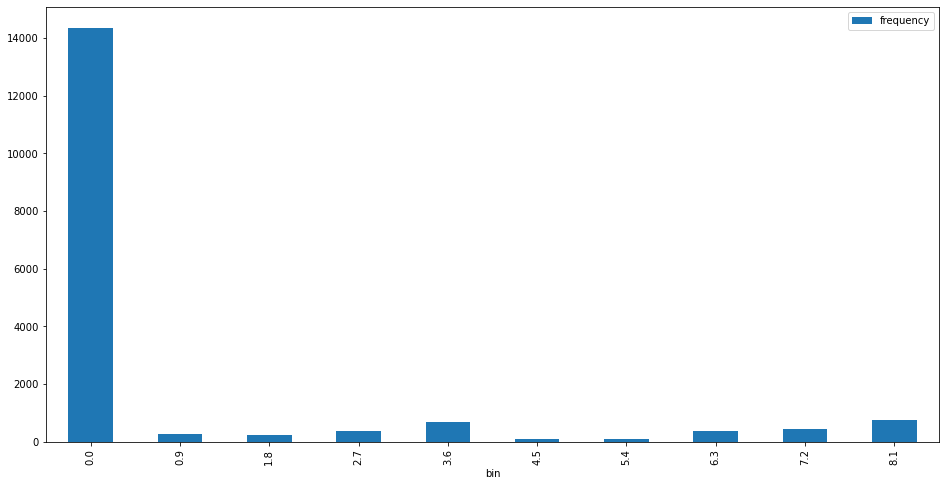

In [38]:
plot_histogram(histogram_lifetime)

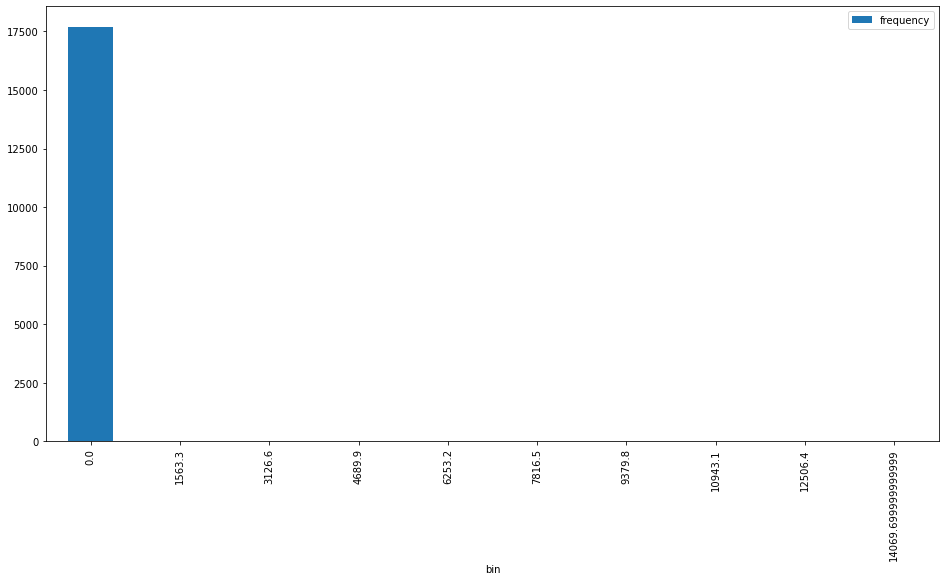

In [39]:
plot_histogram(histogram_weighted_lifetime)

### [MEDIUM] histogram with the avg frequency distribution of the datasets in the last 2y
	- normal histo


In [43]:
histogram_frequency = df_lifetime_freq.select(["Count"]).rdd.flatMap(lambda x: x).histogram(10)

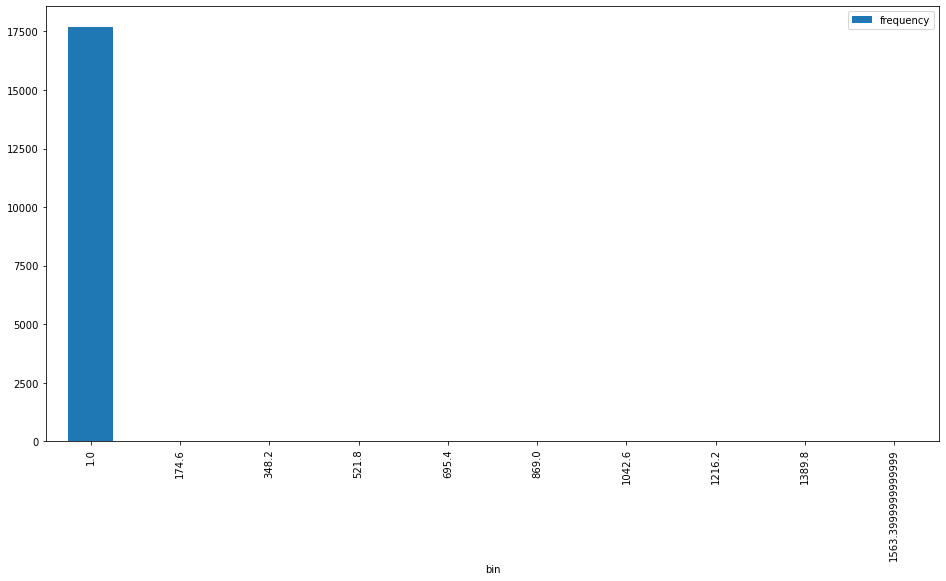

In [44]:
plot_histogram(histogram_frequency)

### [LOW] histogram with the dataset reuse distribution: number of different crab worflow requesting the ds
	- measuring in this way how much a LRU caching can help


In [34]:
histogram_reuse = df_lifetime_reuse.select(["Count"]).rdd.flatMap(lambda x: x).histogram(10)

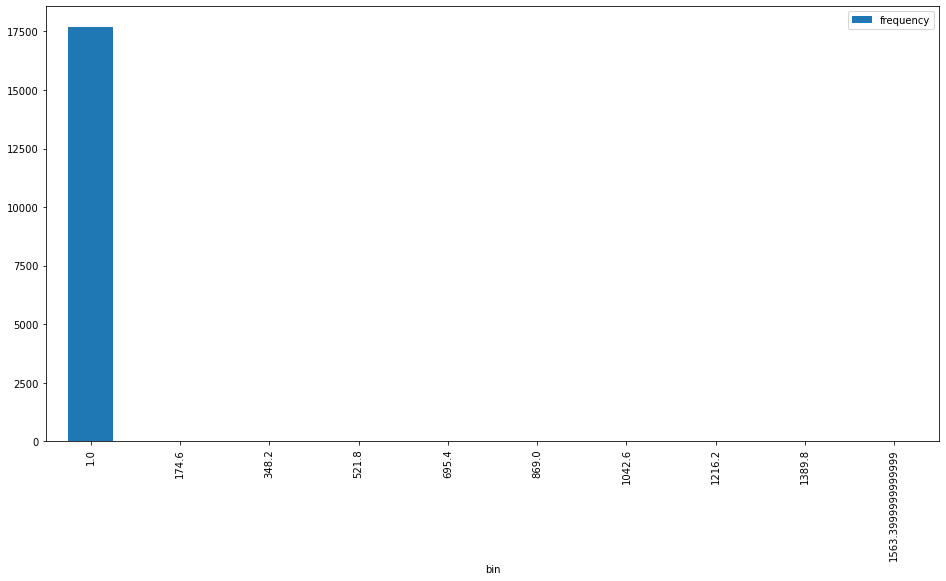

In [37]:
plot_histogram(histogram_reuse)

### [HIGH] pie chart with the average weekly/monthly amount of requested data by data tier


In [67]:
df_week = get_dataset_per_day(7, today)
pd_week = df_week.groupby("CMSPrimaryDataTier").count().toPandas()

using provided date as end_date 2022-09-15


<AxesSubplot:ylabel='count'>

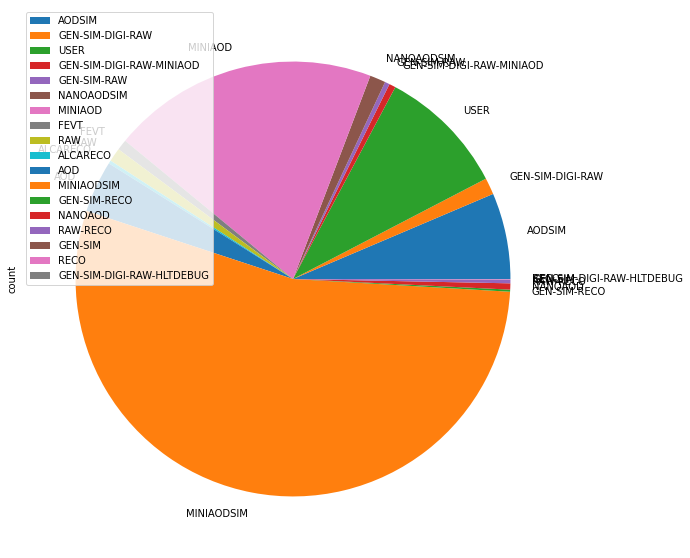

In [68]:
pd_week.set_index('CMSPrimaryDataTier').plot(kind='pie', y='count', figsize=(10, 10))

In [64]:
df_month = get_dataset_per_day(30, today)
pd_month = df_month.groupby("CMSPrimaryDataTier").count().toPandas()

using provided date as end_date 2022-09-15


<AxesSubplot:ylabel='count'>

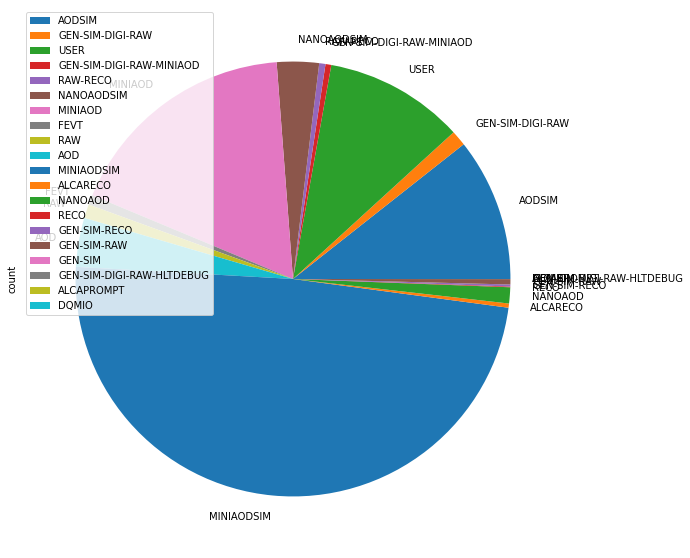

In [65]:
pd_month.set_index('CMSPrimaryDataTier').plot(kind='pie', y='count', figsize=(10, 10))

## Rough Work

## Lifetime distribution of datasets

In [10]:
def get_dataset_lifetime_histogram(days_range, end_date=date.today()):
    
    raw_df = get_raw_df(days_range, end_date)
    # We filter:
    # Events with Submission tool as CRAB
    # Select a single instace of CRAB_Workflow - our concerened field `DESIRED_CMSDataset` is same for all such rows (check assumption check 1)
    # Drop rows with DESIRED_CMSDataset as "null" - these are Monte Carlo jobs and do not require presence of datasets

    df_filtered = raw_df\
            .filter(col("CMS_SubmissionTool")=='CRAB')\
            .filter(col("DESIRED_CMSDataset")!='null')\
            .drop_duplicates(["CRAB_Workflow"])
    
    # We aggregate:
    # Group on DESIRED_CMSDataset
    # - count CRAB_Workflow: this represent the frequency of request of the dataset
    # - count CRAB_UserHN: (Question: how can this help us?) : frequency of unique users requesting that dataset 

    df_aggregated = df_filtered\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(
                 countDistinct(col("CRAB_Workflow")).alias("dataset_request_frequency")
                )\
            .orderBy(col('dataset_request_frequency').desc())
    
    return df_aggregated

In [11]:
days_range, end_date = 730, date.today()
raw_df = get_raw_df(days_range, end_date)
df = raw_df\
        .filter(col("CMS_SubmissionTool")=='CRAB')\
        .filter(col("DESIRED_CMSDataset")!='null')
#         .drop_duplicates(["CRAB_Workflow"])

In [12]:
df_dataset_recordTime = df.groupBy(["CRAB_Workflow", "DESIRED_CMSDataset"]).agg(func.min("RecordTime").alias("rec_time"))
df_lifetime = df_dataset_recordTime.groupby(["DESIRED_CMSDataset"]).agg(func.max("rec_time").alias("max_time"), func.min("rec_time").alias("min_time")).withColumn("lifetime", col("max_time")-col("min_time"))

In [22]:
# df_lifetime.orderBy(col("lifetime").desc()).limit(10).toPandas()

,DESIRED_CMSDataset,max_time,min_time,lifetime
0,/DoubleEG/Run2016G-21Feb2020_UL2016-v1/MINIAOD,1661809681000,1661205601000,604080000
1,/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v2/MINIAODSIM,1661809681000,1661205601000,604080000
2,/WZTo3LNu_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v1/MINIAODSIM,1661809681000,1661205601000,604080000
3,/GJets_DoubleEMEnriched_PtG-40MGG-80_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL16MiniAOD-106X_mcRun2_asymptotic_v13-v1/MINIAODSIM,1661809681000,1661205601000,604080000
4,/ZZTo4L_TuneCP5_13TeV_powheg_pythia8/RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v1/MINIAODSIM,1661809681000,1661205601000,604080000
5,/GJets_DoubleEMEnriched_PtG-20MGG-40To80_TuneCP5_13TeV-madgraphMLM-pythia8/RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v2/MINIAODSIM,1661809681000,1661205601000,604080000
6,/QCD_Pt-20to30_EMEnriched_TuneCP5_13TeV-pythia8/RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v2/MINIAODSIM,1661809681000,1661205601000,604080000
7,/QCD_Pt-50to80_EMEnriched_TuneCP5_13TeV-pythia8/RunIISummer20UL16MiniAODv2-106X_mcRun2_asymptotic_v17-v2/MINIAODSIM,1661809681000,1661205601000,604080000
8,/DoubleEG/Run2016H-21Feb2020_UL2016-v1/MINIAOD,1661809681000,1661205601000,604080000
9,/TTToHadronic_TuneCP5_13TeV-powheg-pythia8/RunIISummer20UL18MiniAODv2-106X_upgrade2018_realistic_v16_L1v1-v1/MINIAODSIM,1661809681000,1661205601000,604080000


In [13]:
df_lifetime.filter(col("lifetime")>720*24*60*60*1000).limit(5).toPandas()

22/08/31 03:08:08 ERROR TransportResponseHandler: Still have 1 requests outstanding when connection from /188.185.34.94:31071 is closed
22/08/31 03:08:08 WARN BlockManagerMasterEndpoint: Error trying to remove broadcast 5 from block manager BlockManagerId(7, ithdp5002.cern.ch, 5107, None)
java.io.IOException: Connection from /188.185.34.94:31071 closed
	at org.apache.spark.network.client.TransportResponseHandler.channelInactive(TransportResponseHandler.java:147)
	at org.apache.spark.network.server.TransportChannelHandler.channelInactive(TransportChannelHandler.java:117)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:262)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelInactive(AbstractChannelHandlerContext.java:248)
	at io.netty.channel.AbstractChannelHandlerContext.fireChannelInactive(AbstractChannelHandlerContext.java:241)
	at io.netty.channel.ChannelInboundHandlerAdapter.channelInactive(ChannelInboundHandle

,DESIRED_CMSDataset,max_time,min_time,lifetime
0,/WJetsToLNu_0J_TuneCP5_13TeV-amcatnloFXFX-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,1661802482000,1598738401000,63064081000
1,/QCD_HT100to200_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,1661326561000,1598738401000,62588160000
2,/DYJetsToLL_M-10to50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v2/MINIAODSIM,1661740561000,1598738401000,63002160000
3,/PAMinimumBias4/PARun2016C-PromptReco-v1/AOD,1661511601000,1598738401000,62773200000
4,/ParkingBPH1/Run2018C-05May2019-v1/MINIAOD,1661595122000,1598738401000,62856721000


In [90]:
#Exploring mappings between jobId and status
raw_df.filter(col("GlobalJobId")=="crab3@vocms0155.cern.ch#43338079.0#1566477179").orderBy(col('CpuTimeHr').desc()).limit(10).toPandas()

,RecordTime,InputData,Status,DESIRED_CMSDataset,CpuTimeHr,RequestCpus,GlobalJobId,CMS_SubmissionTool,CMS_TaskType,TaskType,Type,CRAB_JobType,CMS_JobType,CRAB_ReqName,CRAB_UserHN,USER,Workflow,CRAB_Workflow,CRAB_DataBlock,CMSPrimaryDataTier
0,1661384161000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
1,1661378402000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
2,1661380562000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
3,1661438162000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
4,1661447521000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
5,1661388482000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
6,1661440321000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
7,1661402881000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
8,1661396401000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER
9,1661418002000,Onsite,Held,/EmbeddingRun2018A/MuTauFinalState-inputDoubleMu_102X_miniAOD-v1/USER,0.0,1,crab3@vocms0155.cern.ch#43338079.0#1566477179,CRAB,None,cmsRun,analysis,None,Analysis,None,mgrippo,None,mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,190822_105905:mgrippo_crab_EmbeddingRun2018A_MuTauFinalState,None,USER


In [112]:
raw_df.filter(col("CRAB_Workflow")=="220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8").limit(10).toPandas()

,RecordTime,InputData,Status,DESIRED_CMSDataset,CpuTimeHr,RequestCpus,GlobalJobId,CMS_SubmissionTool,CMS_TaskType,TaskType,Type,CRAB_JobType,CMS_JobType,CRAB_ReqName,CRAB_UserHN,USER,Workflow,CRAB_Workflow,CRAB_DataBlock,CMSPrimaryDataTier
0,1661407316000,Offsite,Completed,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.175556,1,crab3@vocms0195.cern.ch#79576283.0#1661389482,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
1,1661396401000,None,Idle,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.000000,1,crab3@vocms0195.cern.ch#79578690.0#1661393080,CRAB,None,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
2,1661400002000,Onsite,Running,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.100278,1,crab3@vocms0195.cern.ch#79578072.0#1661391495,CRAB,None,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
3,1661400002000,Onsite,Running,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.174167,1,crab3@vocms0195.cern.ch#79546052.0#1661328326,CRAB,None,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
4,1661412241000,Offsite,Running,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.090556,1,crab3@vocms0195.cern.ch#79577410.0#1661389978,CRAB,None,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
5,1661412241000,Onsite,Running,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,1.429444,1,crab3@vocms0195.cern.ch#79546373.0#1661328394,CRAB,None,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM#51835b89-1044-49e4-866d-86d29c6bb261,MINIAODSIM
6,1661393762000,Onsite,Completed,/GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.249722,1,crab3@vocms0195.cern.ch#79577073.0#1661389650,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,dekumar,None,dekumar_crab_GJets_HT-200To400_Tun

In [98]:
raw_df.groupby("CRAB_Workflow").agg(countDistinct("status")).orderBy(col('count(status)').desc()).limit(10).toPandas()

,CRAB_Workflow,count(status)
0,220824_072854:dekumar_crab_GJets_HT-200To400_TuneCP5_13TeV-madgraphMLM-pythia8,5
1,220824_115117:hsaka_crab_TAG106X01_20220824_075051_TTTo2L2Nu_RunIISummer20UL18MiniAODv2-106X,5
2,220824_072131:dekumar_crab_TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8,5
3,220825_113511:jodedra_crab_BuTOKEE2022082550M,5
4,220824_192936:daleyvap_crab_QCD_Pt-30To50_MuEnrichedPt5_RunIISummer20UL17MiniAODv2-106X_mc2017_v9-v2,5
5,220825_085806:cmkuo_crab_job_UL17_QCD_HT100to200,5
6,220824_072457:dekumar_crab_QCD_HT200to300_TuneCP5_13TeV-madgraphMLM-pythia8,5
7,220823_090243:ycheon_crab_20220823_180158,5
8,220825_090043:cmkuo_crab_job_UL18_QCD_HT50to100,5
9,220825_085202:cmkuo_crab_job_UL16_QCD_HT1000to1500_preVFP,5


In [99]:
raw_df.groupby("CRAB_Workflow").agg(countDistinct("status")).orderBy(col('count(status)').asc()).limit(10).toPandas()

,CRAB_Workflow,count(status)
0,220111_142123:dekumar_crab_GJets_HT-600ToInf_TuneCP5_13TeV-madgraphMLM-pythia8,1
1,200710_165302:lwezenbe_crab_SingleMuon_Run2018A,1
2,220720_072007:caime_crab_Filter_BBZZ,1
3,210512_073200:lportale_crab_GluGluToRadionToHHTo2B2Tau_M-700_narrow_TuneCP5_PSWeights_13TeV-madgraph-pythia8_5,1
4,211205_095956:vmariani_crab_Summer16V3_DY_FxFx_M700To800,1
5,200620_123259:nshadski_crab_DYJetsToLL_M-50_HT-200to400_TuneCP5_PSweights_13TeV-madgraphMLM-pythia8_0_0,1
6,220120_111450:abhassan_crab_abhassan_Zto4Electrons_Run2017_PeriodE,1
7,210316_095136:dapparu_crab_MC17_stau494_march2021,1
8,210304_124637:myshched_crab_ZprimeToTauTau_M-3500,1
9,200925_215707:wiwong_crab_diLepFakeRate2018_SingleMuonRun2018A,1


In [94]:
my_df.count()

18233

In [41]:
raw_df = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            ['/project/monitoring/archive/condor/raw/metric/2022/08/10'],
            schema=schema,
        )
        .select("data.*")
        .filter(col("CMS_SubmissionTool")=='CRAB')
    )

In [93]:
raw_df_drop_jobid = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        )
        .select("data.*")
        .drop_duplicates(["GlobalJobId"])
)

raw_df_drop_workflow = raw_df_drop_jobid = (
        spark.read.option("basePath", _DEFAULT_HDFS_FOLDER)
        .json(
            get_candidate_files(start_date, end_date, spark, base=_DEFAULT_HDFS_FOLDER),
            schema=schema,
        )
        .select("data.*")
        .drop_duplicates(["Workflow"])
)

In [96]:
raw_df.select(["Status", "DESIRED_CMSDataset", "CpuTimeHr", "GlobalJobId", "CMS_SubmissionTool", "CRAB_UserHN", "Workflow", "CRAB_Workflow"]).show(25)

+---------+--------------------+-------------------+--------------------+------------------+-----------+--------------------+--------------------+
|   Status|  DESIRED_CMSDataset|          CpuTimeHr|         GlobalJobId|CMS_SubmissionTool|CRAB_UserHN|            Workflow|       CRAB_Workflow|
+---------+--------------------+-------------------+--------------------+------------------+-----------+--------------------+--------------------+
|  Removed|/PAMinimumBias7/P...| 4.4319444444444445|crab3@vocms0197.c...|              CRAB|    rosingh|rosingh_crab_pPb2...|220802_182232:ros...|
|  Removed|/PAMinimumBias7/P...|  2.209722222222222|crab3@vocms0197.c...|              CRAB|    rosingh|rosingh_crab_pPb2...|220802_182232:ros...|
|  Removed|/PAMinimumBias7/P...|             2.3525|crab3@vocms0197.c...|              CRAB|    rosingh|rosingh_crab_pPb2...|220802_182232:ros...|
|  Removed|/PAMinimumBias7/P...|  2.466388888888889|crab3@vocms0197.c...|              CRAB|    rosingh|rosingh_crab_p

22/08/25 10:23:50 WARN BlockManagerMaster: Failed to remove broadcast 29 with removeFromMaster = true - org.apache.spark.SparkException: Could not find BlockManagerEndpoint1.
	at org.apache.spark.rpc.netty.Dispatcher.postMessage(Dispatcher.scala:178)
	at org.apache.spark.rpc.netty.Dispatcher.postRemoteMessage(Dispatcher.scala:136)
	at org.apache.spark.rpc.netty.NettyRpcHandler.receive(NettyRpcEnv.scala:684)
	at org.apache.spark.network.server.TransportRequestHandler.processRpcRequest(TransportRequestHandler.java:163)
	at org.apache.spark.network.server.TransportRequestHandler.handle(TransportRequestHandler.java:109)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:140)
	at org.apache.spark.network.server.TransportChannelHandler.channelRead0(TransportChannelHandler.java:53)
	at io.netty.channel.SimpleChannelInboundHandler.channelRead(SimpleChannelInboundHandler.java:99)
	at io.netty.channel.AbstractChannelHandlerContext.invokeChannelR

In [85]:
#Submission tool frequency by Unique Job Id counts
raw_df.groupby(["CMS_SubmissionTool"]).count().show()

+------------------+-----+
|CMS_SubmissionTool|count|
+------------------+-----+
|              CRAB|36685|
|           WMAgent| 5743|
|         Condor_SI|    2|
+------------------+-----+



In [61]:
raw_df.drop_duplicates(["CRAB_Workflow"]).groupby("GlobalJobId").count().sort(col("count").desc()).limit(10).toPandas()

,GlobalJobId,count
0,crab3@vocms0137.cern.ch#61354817.0#1613714538,1
1,crab3@vocms0195.cern.ch#75780287.0#1651505175,1
2,crab3@vocms0196.cern.ch#59462730.0#1608640424,1
3,crab3@vocms0155.cern.ch#77572252.0#1641406615,1
4,crab3@vocms0197.cern.ch#77158490.0#1651403564,1
5,crab3@vocms0199.cern.ch#14331680.0#1593543413,1
6,crab3@vocms0106.cern.ch#45150947.0#1595597496,1
7,crab3@vocms0121.cern.ch#76872232.0#1649161807,1
8,crab3@vocms0194.cern.ch#53590930.0#1591904656,1
9,crab3@vocms0155.cern.ch#70889807.0#1625799568,1


In [60]:
raw_df.drop_duplicates(["GlobalJobId"]).groupby("CRAB_Workflow").count().sort(col("count").desc()).limit(10).toPandas()

,CRAB_Workflow,count
0,None,792849
1,220810_020314:osuranyi_crab_JetHT_photons_HLTrerun,16064
2,220809_130447:sixie_crab_Fall18_ParticleGun_uquark_pt60_GENSIM_batch1,14142
3,220809_152844:mkomm_crab_TopPhilic_tttt_masscan_relwidth10_miniaodUL16v2_220727,11003
4,220810_081930:astepenn_crab_TAG106X00_20220810_041905_SingleMuon_Run2018D-UL2018,9818
5,220809_125621:sixie_crab_Fall18_ZHToSS_SToPi0Pi0_ms1p0_pl125_GENSIM_batch6,9522
6,220809_130029:sixie_crab_Fall18_ParticleGun_uquark_pt30_GENSIM_batch1,9256
7,220809_152927:mkomm_crab_TopPhilic_tttt_masscan_relwidth50_miniaodUL16v2_220727,8878
8,220809_131036:sixie_crab_Fall18_ParticleGun_uquark_pt300_GENSIM_batch1,8162
9,220810_075654:jiahua_crab_DPS_etabto4mu_SKIM,7925


In [50]:
raw_df.filter(col("DESIRED_CMSDataset").contains("#")).select(["DESIRED_CMSDataset"]).show()

+------------------+
|DESIRED_CMSDataset|
+------------------+
+------------------+



In [64]:
raw_df.filter(col("Workflow")=="osuranyi_crab_JetHT_photons_HLTrerun").sort(col("CRAB_Workflow")).limit(10).toPandas()

,RecordTime,InputData,Status,DESIRED_CMSDataset,CpuTimeHr,RequestCpus,GlobalJobId,CMS_SubmissionTool,CMS_TaskType,TaskType,Type,CRAB_JobType,CMS_JobType,CRAB_ReqName,CRAB_UserHN,USER,Workflow,CRAB_Workflow,CRAB_DataBlock,CMSPrimaryDataTier
0,1660091404000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.331111,1,crab3@vocms0137.cern.ch#81572459.0#1660085575,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
1,1660091404000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.331111,1,crab3@vocms0137.cern.ch#81572459.0#1660085575,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
2,1660091451000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.401944,1,crab3@vocms0137.cern.ch#81572216.0#1660085500,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
3,1660094514000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.549722,1,crab3@vocms0137.cern.ch#81573012.0#1660086133,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
4,1660094290000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.026944,1,crab3@vocms0137.cern.ch#81573009.0#1660086132,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
5,1660094514000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.549722,1,crab3@vocms0137.cern.ch#81573012.0#1660086133,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
6,1660091404000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.331111,1,crab3@vocms0137.cern.ch#81572459.0#1660085575,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
7,1660095476000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.099444,1,crab3@vocms0137.cern.ch#81572762.0#1660085824,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
8,1660094514000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.549722,1,crab3@vocms0137.cern.ch#81573012.0#1660086133,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD
9,1660094290000,Offsite,Removed,/JetHT/Run2022C-PromptReco-v1/MINIAOD,0.026944,1,crab3@vocms0137.cern.ch#81573009.0#1660086132,CRAB,cmsRun,cmsRun,analysis,None,Analysis,None,osuranyi,None,osuranyi_crab_JetHT_photons_HLTrerun,220809_224528:osuranyi_crab_JetHT_photons_HLTrerun,/JetHT/Run2022C-PromptReco-v1/MINIAOD#dc76d4ca-a8e0-473a-83bb-f3740187dc4d,MINIAOD


In [49]:
raw_df.filter(col("GlobalJobId")=="cmsgwms-submit4.fnal.gov#458695.77#1659948216").limit(10).toPandas()

,RecordTime,InputData,Status,DESIRED_CMSDataset,CpuTimeHr,RequestCpus,GlobalJobId,CMS_SubmissionTool,CMS_TaskType,TaskType,Type,CRAB_JobType,CMS_JobType,CRAB_ReqName,CRAB_UserHN,USER,Workflow,CRAB_Workflow,CRAB_DataBlock,CMSPrimaryDataTier
0,1660122001000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
1,1660137121000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
2,1660130642000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
3,1660160881000,Onsite,Running,None,12.221111,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
4,1660129201000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
5,1660145762000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
6,1660108321000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
7,1660155121000,Onsite,Running,None,6.405556,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
8,1660150801000,Onsite,Running,None,1.356944,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown
9,1660144322000,None,Idle,None,0.000000,4,cmsgwms-submit4.fnal.gov#458695.77#1659948216,WMAgent,None,DIGI,production,None,Production,None,None,None,HIG-RunIISummer20UL16wmLHEGENAPV-03603,None,None,Unknown


In [48]:
raw_df.groupby("GlobalJobId").count().limit(10).toPandas()

,GlobalJobId,count
0,cmsgwms-submit4.fnal.gov#458695.77#1659948216,120
1,crab3@vocms0122.cern.ch#82775307.0#1651337459,120
2,crab3@vocms0120.cern.ch#65304946.0#1619514021,120
3,crab3@vocms0155.cern.ch#85775099.0#1660143501,6
4,vocms0255.cern.ch#16593.43#1660114657,59
5,SUBMIT04.MIT.EDU#212652.4081#1660130460,63
6,vocms0255.cern.ch#16679.190#1660125778,49
7,crab3@vocms0195.cern.ch#79075015.0#1660127169,67
8,crab3@vocms0195.cern.ch#79082225.0#1660143999,24
9,crab3@vocms0121.cern.ch#50854932.0#1583762532,120


In [46]:
raw_df.groupby("GlobalJobId").agg(countDistinct("DESIRED_CMSDataset")).filter(col("count(DESIRED_CMSDataset)")>1).show()

+-----------+-------------------------+
|GlobalJobId|count(DESIRED_CMSDataset)|
+-----------+-------------------------+
+-----------+-------------------------+



In [53]:
raw_df.filter(col("CMS_SubmissionTool")=="CRAB").groupby("CRAB_Workflow").agg(countDistinct("DESIRED_CMSDataset")).filter(col("count(DESIRED_CMSDataset)")>1).show()

+-------------+-------------------------+
|CRAB_Workflow|count(DESIRED_CMSDataset)|
+-------------+-------------------------+
+-------------+-------------------------+



In [101]:
my_df = raw_df.select(col('DESIRED_CMSDataset'),\
                    col('CpuTimeHr'),\
                    col('CRAB_UserHN'),\
                    col('CRAB_Workflow'))\
            .groupby(col('DESIRED_CMSDataset'))\
            .agg(_sum("CpuTimeHr").alias("sum_CpuTimeHr"),\
                countDistinct(col("CRAB_UserHN")).alias("distinct_CRAB_UserHN"),
                countDistinct(col("CRAB_Workflow")).alias("distinct_Workflow"))\
            .orderBy(col('distinct_CRAB_UserHN').desc())

In [102]:
my_df.count()

13551

In [103]:
my_df.limit(20).toPandas()

,DESIRED_CMSDataset,sum_CpuTimeHr,distinct_CRAB_UserHN,distinct_Workflow
0,None,4.807460e+07,193,188
1,/SingleMuon/Run2018A-17Sep2018-v2/MINIAOD,0.000000e+00,24,62
2,/TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.000000e+00,23,74
3,/SingleMuon/Run2018B-17Sep2018-v1/MINIAOD,0.000000e+00,21,59
4,/TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.000000e+00,20,43
5,/DYJetsToLL_M-50_TuneCP5_13TeV-madgraphMLM-pythia8/RunIIAutumn18MiniAOD-102X_upgrade2018_realistic_v15-v1/MINIAODSIM,0.000000e+00,20,70
6,/SingleMuon/Run2018C-17Sep2018-v1/MINIAOD,0.000000e+00,20,53
7,/SingleMuon/Run2016H-17Jul2018-v1/MINIAOD,0.000000e+00,20,102
8,/SingleMuon/Run2017D-31Mar2018-v1/MINIAOD,0.000000e+00,19,42
9,/SingleMuon/Run2017C-UL2017_MiniAODv2-v1/MINIAOD,1.297437e+05,19,60


### Assumption checks

#### Check 1: One to one mapping between DESIRED_CMSDataset and CRAB_Workflow

In [21]:
raw_df.select(["DESIRED_CMSDataset", "CRAB_Workflow"]).groupby("CRAB_Workflow").agg(countDistinct("DESIRED_CMSDataset").alias("single_worflow_dataset_count")).filter(col("single_worflow_dataset_count") > 1).show()

+-------------+----------------------------+
|CRAB_Workflow|single_worflow_dataset_count|
+-------------+----------------------------+
|         null|                         215|
+-------------+----------------------------+



In [121]:
raw_df = get_raw_df(1)

In [123]:
raw_df.filter(col("DESIRED_CMSDataset").isNull()).show(20,False)

+-------------+---------+---------+------------------+------------------+-----------+----------------------------------------------+------------------+------------+--------+----------+------------+-----------+------------+-----------+----+----------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------+--------------+------------------+
|RecordTime   |InputData|Status   |DESIRED_CMSDataset|CpuTimeHr         |RequestCpus|GlobalJobId                                   |CMS_SubmissionTool|CMS_TaskType|TaskType|Type      |CRAB_JobType|CMS_JobType|CRAB_ReqName|CRAB_UserHN|USER|Workflow                                                                                |CRAB_Workflow                                                                                         |CRAB_DataBlock|CMSPrimaryDataTier|
+-------------+---------+---------+------------------+--------------